# Mamba на пальцах
### Адаптация и перевод оригинальной [работы](https://github.com/hkproj/mamba-notes/blob/main/Mamba_Slides.pdf) Umar Jamil, а так же его [видео](https://www.youtube.com/watch?v=8Q_tqwpTpVU)

Автор: Наказненко Павел

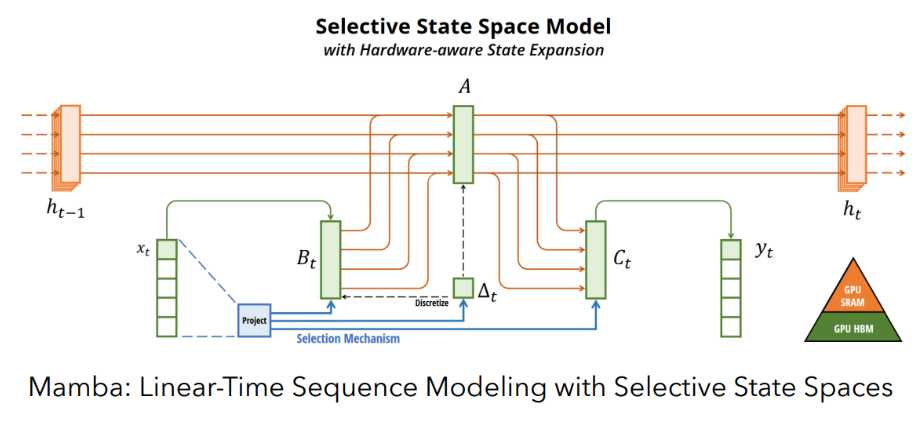

## 1. Введение

[Оригинал статьи](https://arxiv.org/abs/2312.00752)

[Официальная имплементация](https://github.com/state-spaces/mamba/tree/main)


Начнем с проблематики и вообще откуда взялась Mamba.

Есть задача обработки последовательности. Например, хотим решать задачу моделирования естественного языка, генерируя текст.

Последовательность можно обрабатывать несколькими способами:
1. RNN, то есть с помощью рекурентных нейросетей. Теоретически работает для очень больших последовательностей, но на практике есть проблемы: например, параллелить не получится (в классической имплементации), а так же подход страдает от взрывающиеся\затухающих градиентов.
2. CNN, то есть с помощью сверточных нейросетей. Тоже работает, даже неплохо параллелится. Сложность обучения и инференса зависит от размера ядра.
3. С помощью Transformer-based решений. Очень хорошо параллелится, сложность инференса при наличии KV-Cache вообще растет линейно, но вот тренировать дороговато O(N*N)
4. State Space Models. Представим задачу обработки последовательности в виде модели пространства состояний. Эта модель лежит в основе Mamba.

## 2. State Space Models

Сам термин State Space Models появился благодаря термину [State Space Representation](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%BE_%D1%81%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B9_(%D1%82%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D1%83%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F), пришедшему из Теории Управления.

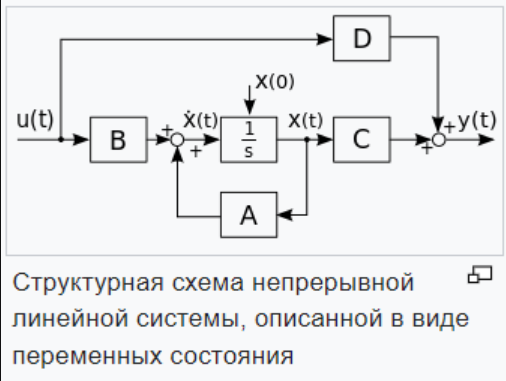

Если на пальцах, то суть такова:

У нас есть некоторая динамическая система, которая меняет свое состояние, обрабатывая входные данные некоторым образом, возвращаюая некоторый результат. При этом связаны все эти переменные линейно и с помощью диффернциальных уравнений первого порядка.
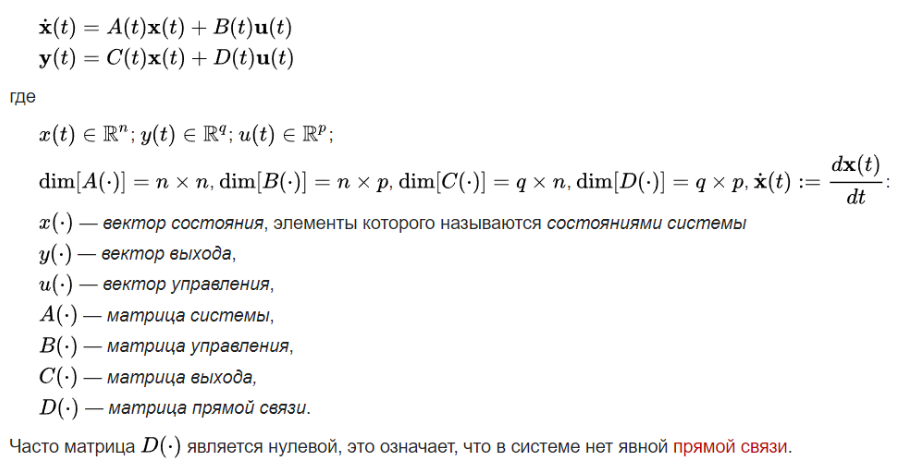

Чтобы в каждый момент времени посчитать значение *y(t)* нам нужно найти функцию *x(t)*, которая описывает состояние системы в любой точке всего временного отрезка.

Аналитечски решать такое неудобно и трудно. К тому же, в нашем случае речь идет не о непрерывном сигнале, а о дискретном. 

Поэтому нам нужно сделать дискретизацию нашей системы.

## 3. Дискретизация системы

Чтобы не решать диффернциальные уравнения аналитически, решим их численными методами. 
Для этого можно использовать различные способы. Например, [методом Эйлера](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%AD%D0%B9%D0%BB%D0%B5%D1%80%D0%B0) , либо в общем случае методом [Рунге-Кутты](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%A0%D1%83%D0%BD%D0%B3%D0%B5_%E2%80%94_%D0%9A%D1%83%D1%82%D1%82%D1%8B).

Тогда дискретизированная система будет иметь вид


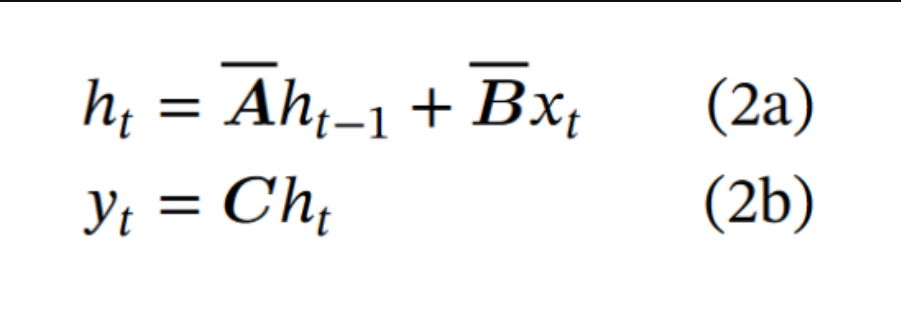

_Замечу_, что здесть нет слогаемого с матрицей *D* , потому что подразумевается, что система не содержит прямой связи. 

Дли дискретизации авторы статьи решили использовать метод _Zero-Order Hold_ для дискретизации непрерывных значений. Суть заключается в том, что у нас есть некоторые функции, которые преобразуют матрицы A и B соответственно какому-то правилу.
В данном случае:

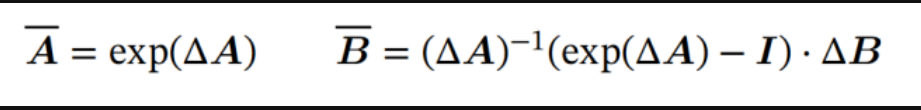

при этом шаг дискретизации дельта не выбирается вручную, а учится сетью самостоятельно.

Таким образом получаем вполне себе рекурентную модель:

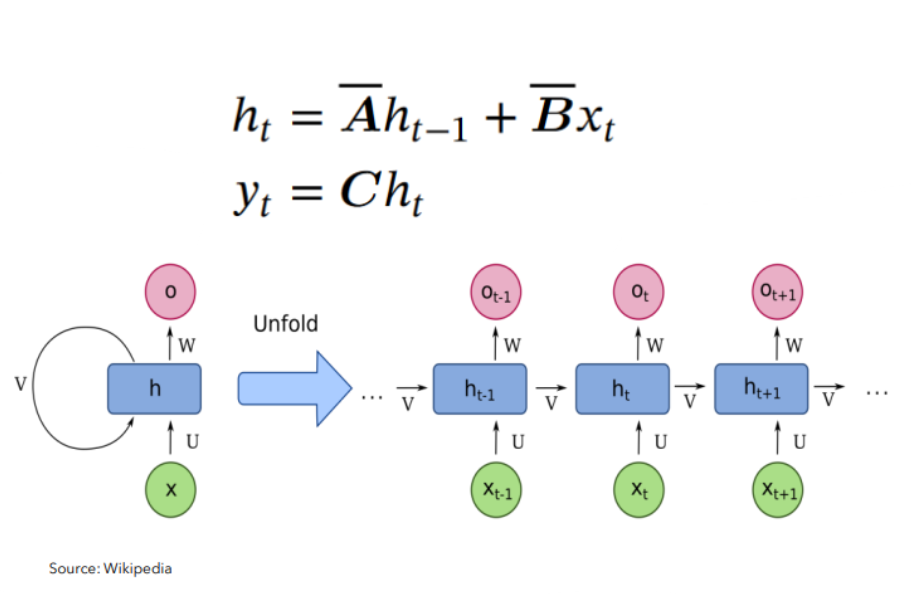

Что говоришь мальчишка? *"Так это же, считай, почти что RNN! В чем прикол?"*

Дельное замечание! И впрямь, на данный момент такая рекурентная формулировка не шибко отличается от обычной рекурентной сети. И проблемы с ней те же: вычисления не параллелятся, например. Однако здесь нам на помощь приходит трюк со сверткой.

## 4. Свертка

Взглянем на то, как последовательно вычисляются значения в нашей системе начиная с *t = 0*:

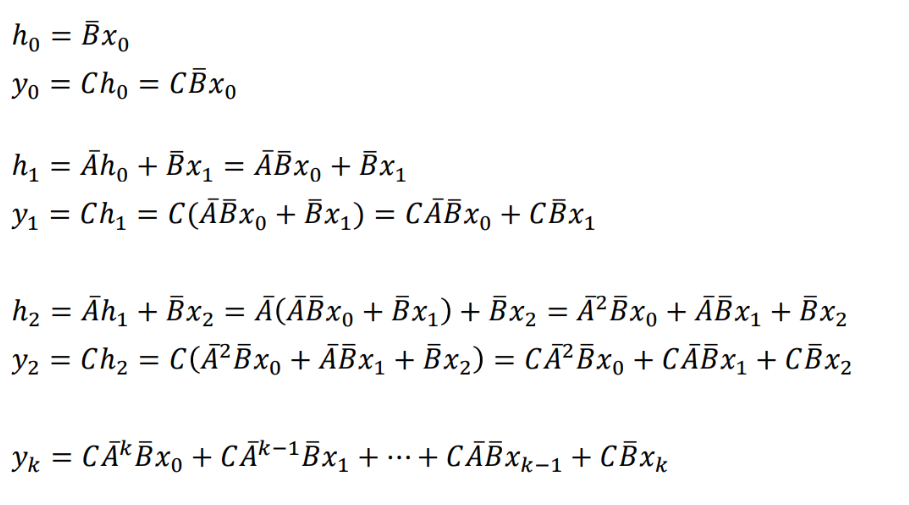

*"Несложно заметить" (с) -Любой преподаватель* 

что выражение

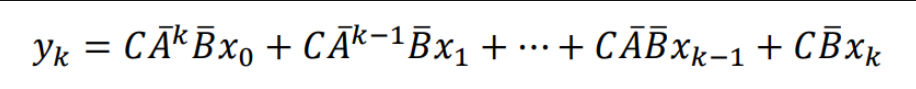

можно представить в виде оператора свертки (convolution):

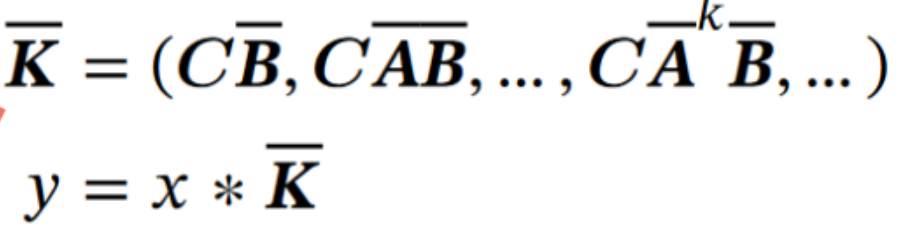

А свертки, как мы знаем, хорошечно параллелятся. А потому:

1. Во время тренировки мы используем подход со сверткой, при этом эффективно считаем с помощью параллельных вычислений
2. Во время инференса, нам достаточно считать рекурентно, без свертки, с небольшим постоянным количеством используемой памяти.

### Очень важный нюанс:
Вот такая _State Space Model_ в имплементации [S4](https://srush.github.io/annotated-s4/) и последующих считается для каждого измерения входных данных.

То есть, если на входе у нас эмбеддинг с размерностью 512, то у нас получается 512 индвидуальных блоков. Можно воспринимать это как трансформер с 512 attention головами.

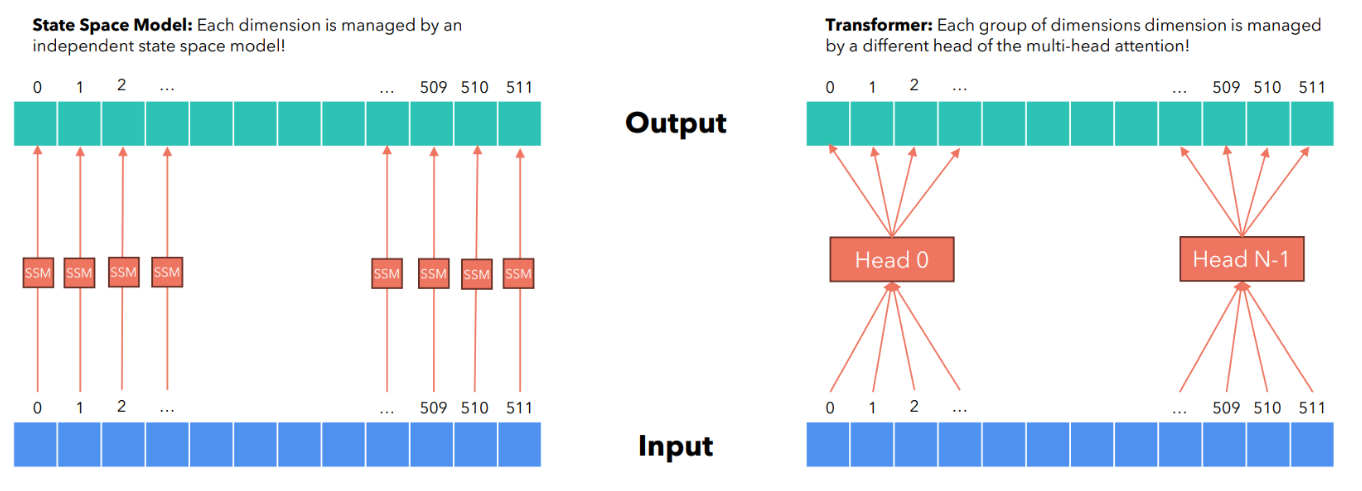

## 5. Что за матрицы А,В,С?

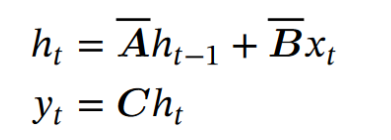

Если на пальцах, то:
- Матрица *A* отвечает за то, как обработать информацию прошлого состояния передать дальше
- Матрица *В* отвечает за то, как обработать информацию из текущего входа и "вмешать" в текущее состояние
- Матрица *С* отвечает за то, как обработать информацию из текущего состояния для результата на выходе

Для задачи языкового моделирования очень важна матрица *А* , т.к. именно она отвечает за зависимость текущего токена от предыдущих.

Как [оказывается](https://arxiv.org/abs/2008.07669) SSM так себе справляются с запоминанием в классической имплементации из-за масштабов градиентов, поэтому было предложена техника [HiPPO](https://arxiv.org/abs/2008.07669).

Суть техники такова: Мы строим матрицу А для запоминания входящей последовательности так, что в ней находятся коэфициэнты для [многочленов Лежандра](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%9B%D0%B5%D0%B6%D0%B0%D0%BD%D0%B4%D1%80%D0%B0) . 

Это как если бы мы делали преобразование Фурье к входному сигналу для всей последовательности, только домен другой. Только здесь мы аппроксимируем не весь сигнал с одинаковой точностью, а уделяем больше "внимания" недавним значениям, нежели прошлым.

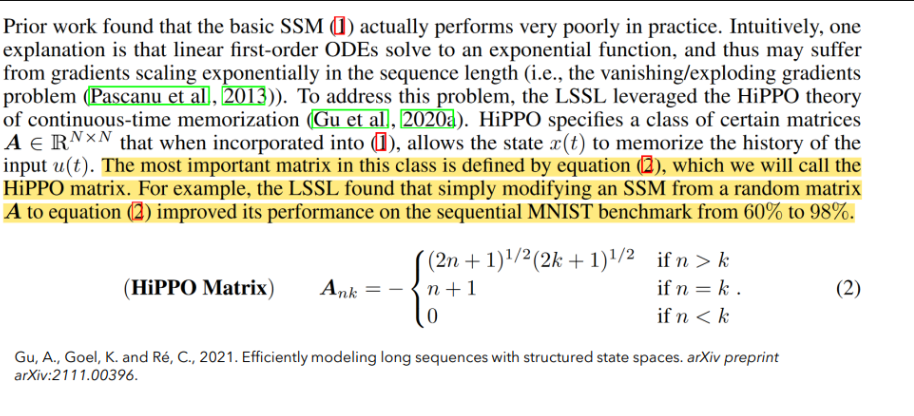

Вроде бы все круто, но есть нюанс.

# 6. S4 работает, но не для всех задач

Дело в том, что та архитектура, которую мы описали к настоящему моменту - это еще не Mamba. Это [Structured State Space Model](https://arxiv.org/abs/2111.00396).

Хотя она неплохо справляется с задачей копирования\воспроизведения неперырвных(!) сегментов последовательности, избирательное копирование такая модель делать не способна. Например, если нам нужно скопировать не кусочек в 5 токенов, а каждый пятый токен, то модель не справится.

Это вызвано тем, что наши матрицы *A,B,C* зависят от времени (как понятия течения последовательности), но не content-aware (в понимании течения времени). По этой же причине, в индукцию S4 модели тоже не умеют.

И вот тут вступают авторы Mamba!

# 7. Mamba (она же S6)

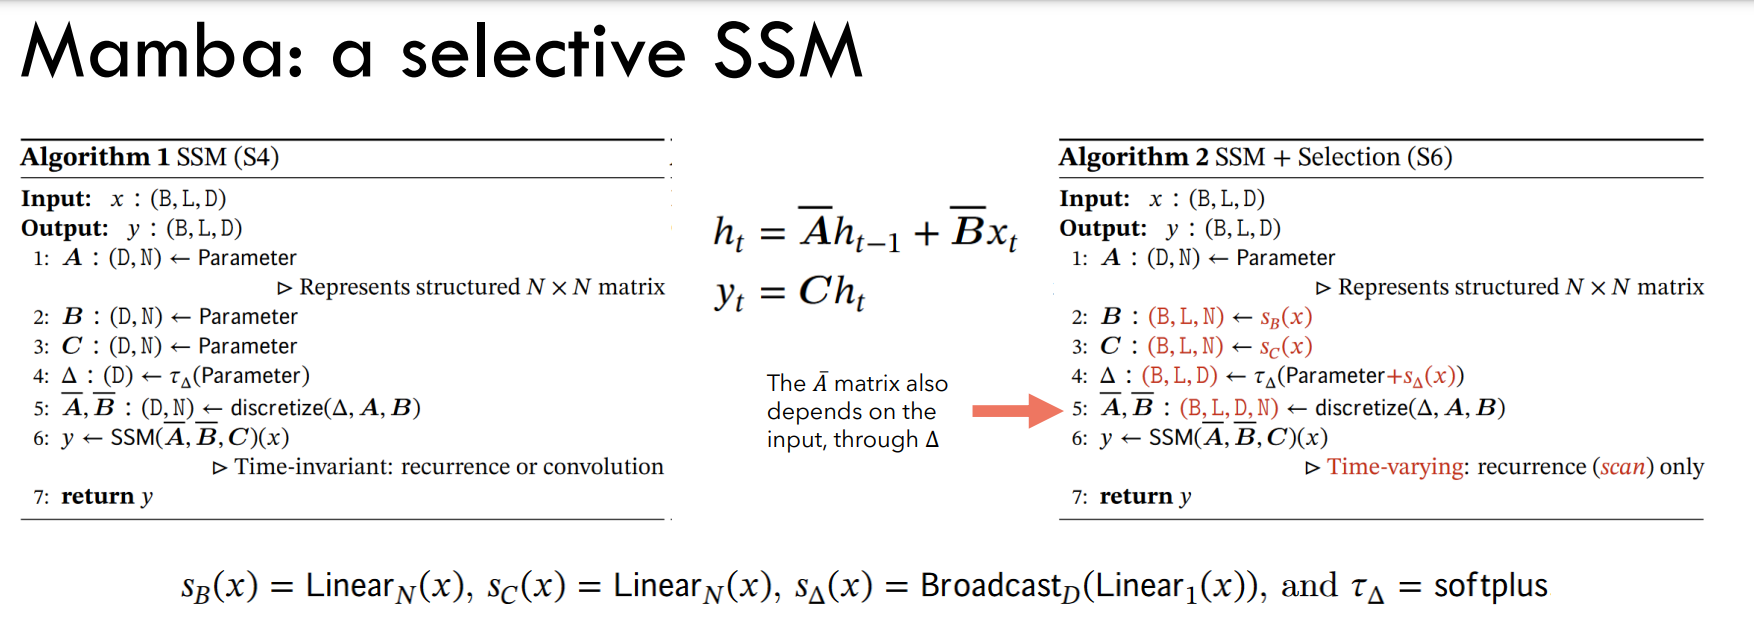 
Авторы предложили следующее: а давайте пожертвуем оптимизацией с помощью свертки, но зато матрицы *B* и *C* теперь перестанут быть независимыми от времени и мы их будем учить во время тренировки.

Так как свертки у нас теперь нет, чтобы при этом алгоритм оставался быстрым и стабильным, мы воспользуемся рядом оптимизаций.
1. Вместо свертки у нас теперь операция *scan*, которая математически эквивалентна прошлому применению свертки в S4 и является ничем иным как ["префиксной суммой"](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D1%84%D0%B8%D0%BA%D1%81%D0%BD%D0%B0%D1%8F_%D1%81%D1%83%D0%BC%D0%BC%D0%B0). Сложность такого подсчета *O(N)*
2. Префиксная сумма хороша тем, что если у нас работает правило ассоциативности, то мы можем считать ее параллельно (*parallel scan*) и сложность становится *O(N/T)*, где *T* - количество рабочих потоков. Трюк с параллельно вычисляемой префиксной суммой довольно старый, ему лет 20 наверное.
3. Kernel fusion - вместо того, чтобы постоянно таскать результаты вычислений между DRAM и SRAM, давайте вычисления сольем в одну операцию так, чтобы одина раз загрузить из DRAM, посчитать все в SRAM, а затем один раз выгрузить обратно в DRAM.
4. Чтобы лишний раз не грузить значение градиентов в графе вычислений из DRAM в SRAM и обратно, авторы предлагают трюк для перерасчета этих градиентов налету, когда понадбятся.

Вот так выглядит Mamba:

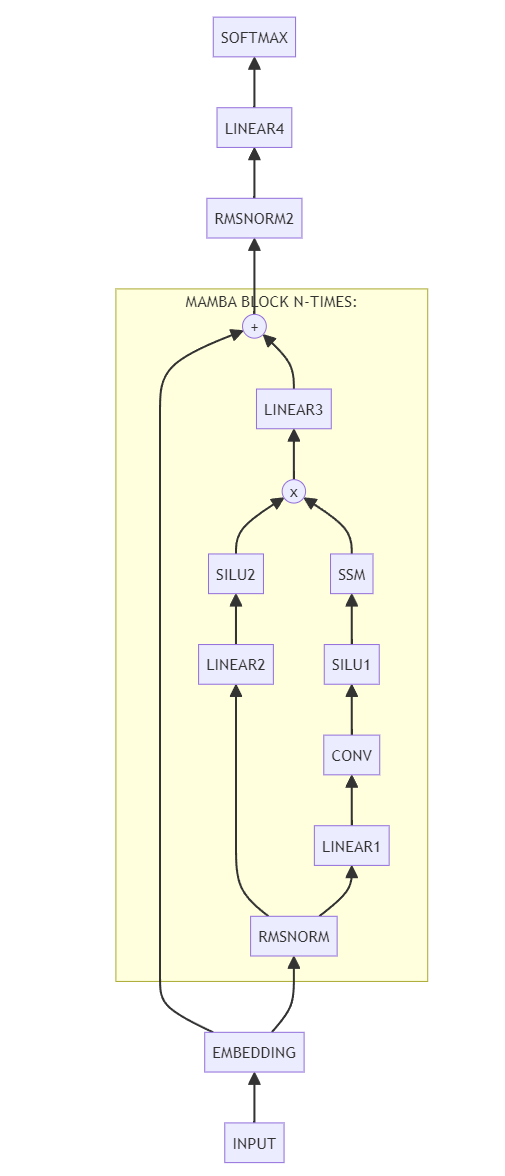

## 7. Результаты и перформанс

Подробно можно ознакомиться в [оригинале статьи](https://arxiv.org/abs/2312.00752).

# 8. You are amazing! You really are.